<a href="https://colab.research.google.com/github/JieyuZhang97/fastai_NN/blob/master/sky_fastai_p1_lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Admin stuff 

- mount the google drive 
- import necessary packages 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore")

# Download the pictures from Google Images 

- open Google Image 
- type the search word
- at the result page, press ctrl+shift+j
- copy paste the following: **urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));**
- this will open a download page. Save the file as a csv in the same folder for storing the downloaded pictures. 

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies')
path.mkdir(parents=True, exist_ok=True)

## Download pictures into the correspoding folders

In [ ]:

folder = 'haze_old'
file = 'haze_sky.csv'

dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(path/file, dest, max_pics=200)

In [ ]:
folder = 'cloudy_old'
file = 'cloudy_sky.csv'

dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(path/file, dest, max_pics=200)

## Check if the figures are indeed figures

In [ ]:
classes = ['cloudy_old','haze_old']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cloudy


haze


## Split the data into training(80%) and validation(20%) sets 

In [ ]:
 ## make sure there are no irrelavant files / folders in the path 
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/sunny_sky.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/cloudy_sky.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/haze_sky.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/haze'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/cloudy')]

In [ ]:
np.random.seed(42) # make sure the validation set is always the same 
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats) # valid_pct -> automatically set the validation set percent as 20% 

In [ ]:
## inspect the training and validation data sets
data 

ImageDataBunch;

Train: LabelList (320 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
haze,haze,haze,haze,haze
Path: /content/drive/My Drive/Colab Notebooks/fastai_p1/skies;

Valid: LabelList (80 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cloudy,cloudy,haze,cloudy,haze
Path: /content/drive/My Drive/Colab Notebooks/fastai_p1/skies;

Test: None

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cloudy', 'haze'], 2, 320, 80)

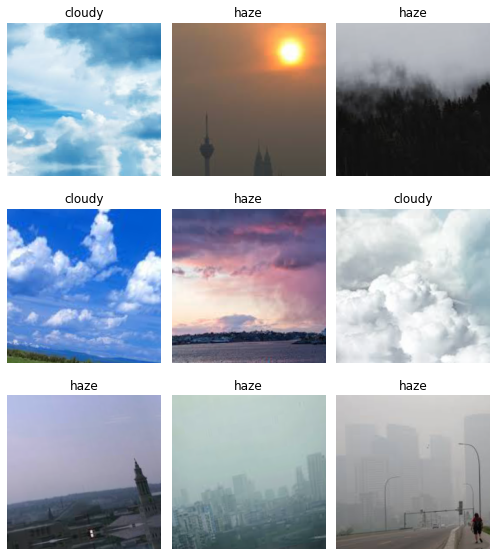

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

# Train the data set with resnet34

In [ ]:
# load the resnet34 network 
learn_two_skies = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
# train the model 
learn_two_skies.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.961121,0.517738,0.225000,00:07
1,0.626734,0.729329,0.150000,00:06
2,0.494633,0.731257,0.087500,00:06
3,0.434188,0.666411,0.100000,00:06


## Tuning the model with the optimal learning rate range 

In [ ]:
learn_two_skies.unfreeze()
learn_two_skies.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


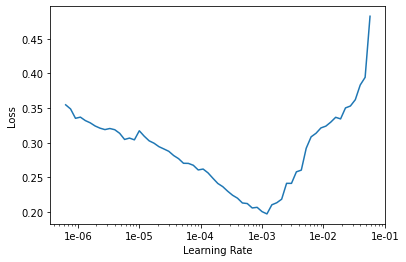

In [ ]:
## plot the loss with learning rates
learn_two_skies.recorder.plot()

In [ ]:
## fit the model with ideal learning rate range 
learn_two_skies.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.268806,0.579632,0.087500,00:07
1,0.181819,0.558894,0.087500,00:07


In [ ]:
learn_two_skies.save('stage-2')

# Export the trained model 

In [ ]:

learn_two_skies.export("learn_two_skies.pkl")
learn_two_skies.export()

# Test the model 

In [ ]:
defaults.device = torch.device('cpu')

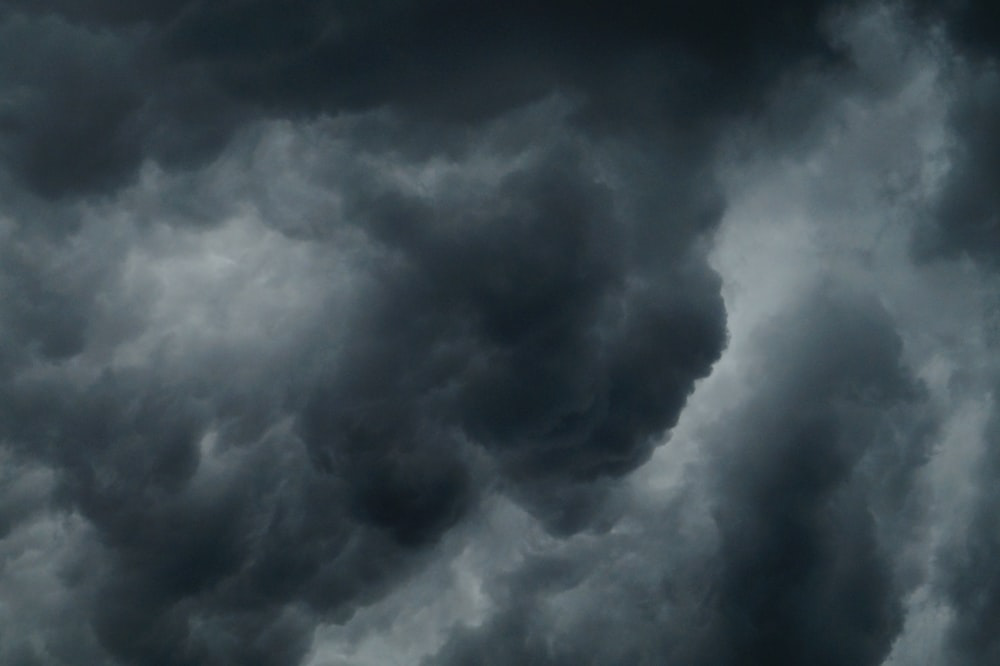

In [ ]:
img = open_image("/content/drive/My Drive/Colab Notebooks/fastai_p1/test_sky.jpg")
img

In [ ]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'cloudy'

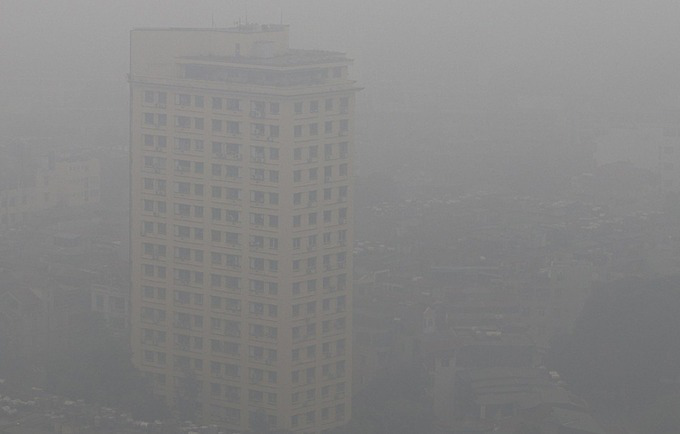

In [ ]:
img_2 = open_image("/content/drive/My Drive/Colab Notebooks/fastai_p1/test_sky_2.jpg")
img_2

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img_2)
pred_class.obj

'haze'

# Fine tuning the data set 

I looked into all the pictures and documented all the file names that were not what I wanted. Then I deleted these pictures and retrained the model. This time the model accuracy increased to 91%. However, the cross validation error after unfreezing the network still remains NaN. I am not sure what went wrong. 


In [ ]:
import os
import pandas as pd

In [ ]:
## import the csv file with file names to delete in the haze folder 
haze_delete = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/haze_false.txt', delimiter = "\t",
                          names=["pic_number"],dtype={'pic_number': object})

In [ ]:
haze_delete.head(5)

,pic_number
0,00000007
1,00000009
2,00000010
3,00000011
4,00000013


In [ ]:
for i in range(len(haze_delete['pic_number'])):
  path_pic = "/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/haze/" + haze_delete['pic_number'][i] + ".jpg"
  os.remove(path_pic)

print("Unwanted files removed!")

Unwanted files removed!


In [ ]:
## import the csv file with file names to delete in the cloudy folder 
cloudy_delete = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/cloudy_false.txt', delimiter = "\t",
                          names=["pic_number"],dtype={'pic_number': object})


cloudy_delete.head()

,pic_number
0,00000074
1,00000081
2,00000158
3,00000186


In [ ]:
for i in range(len(cloudy_delete['pic_number'])):
  path_pic = "/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/cloudy/" + cloudy_delete['pic_number'][i] + ".jpg"
  os.remove(path_pic)

print("Unwanted files removed!")

Unwanted files removed!


In [ ]:
## move the cleaned folders to a new folder naming new_skies 
path = Path('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/new_skies')
path.mkdir(parents=True, exist_ok=True)

## make sure there are no irrelavant files / folders in the path 
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/new_skies/haze'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai_p1/skies/new_skies/cloudy')]

In [ ]:
np.random.seed(42) # make sure the validation set is always the same 
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats) 

In [ ]:
data

ImageDataBunch;

Train: LabelList (289 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
haze,haze,haze,haze,haze
Path: /content/drive/My Drive/Colab Notebooks/fastai_p1/skies/new_skies;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
haze,haze,haze,cloudy,haze
Path: /content/drive/My Drive/Colab Notebooks/fastai_p1/skies/new_skies;

Test: None

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['cloudy', 'haze'], 2, 289, 72)

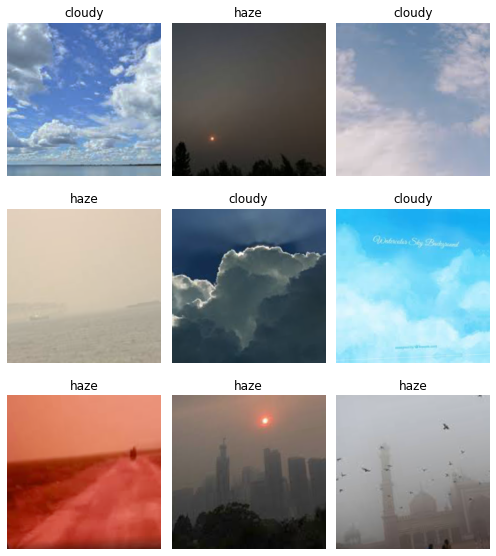

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

#Retrain the model with the edited data set 

In [ ]:
# load the resnet34 network 
learn_two_skies_new = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_two_skies_new.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.137611,0.240952,0.083333,01:01
1,0.755517,0.268611,0.055556,00:08
2,0.575406,0.196275,0.027778,00:05
3,0.504609,0.149731,0.027778,00:05


In [ ]:
learn_two_skies_new.unfreeze()

In [ ]:
learn_two_skies_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


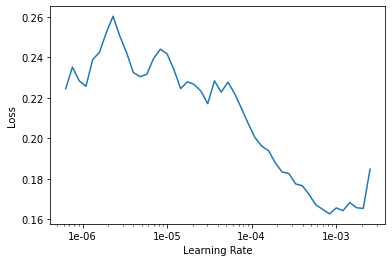

In [ ]:
## plot the loss with learning rates
learn_two_skies_new.recorder.plot()

In [ ]:
## fit the model with ideal learning rate range 
learn_two_skies_new.fit_one_cycle(2, max_lr=slice(1e-4,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.049103,0.029810,0.013889,00:05
1,0.033737,0.028076,0.013889,00:05


# Test the model again 

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
learn_two_skies_new.export()

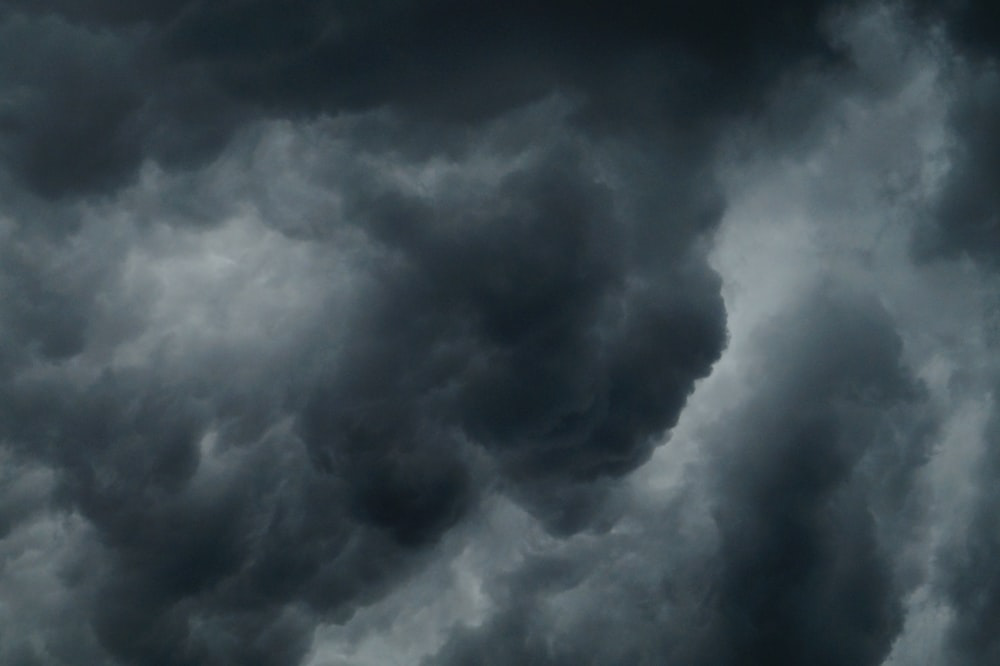

In [ ]:
img = open_image("/content/drive/My Drive/Colab Notebooks/fastai_p1/test_sky.jpg")
img

In [ ]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'cloudy'

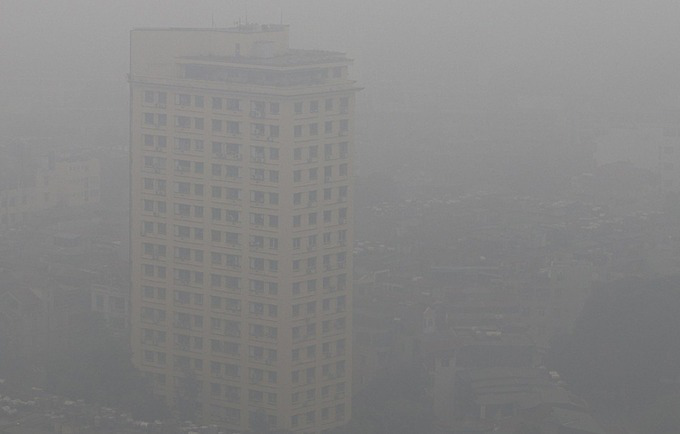

In [ ]:
img_2 = open_image("/content/drive/My Drive/Colab Notebooks/fastai_p1/test_sky_2.jpg")
img_2

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img_2)
pred_class.obj

'haze'